# Problem Set 1: Whale Oil Demand Analysis

This analysis examined historical whale oil market data from 1804-1914.

`Anton Melnychuk`

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv('whales_demand.csv')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (110, 8)


,year,price_sperm,price_oil,price_sperm_real,price_oil_real,sperm,oil,shipwrecks
0,1804,1.40,0.50,1.11,0.40,8.636,114.1065,0.064167
1,1805,0.96,0.50,0.68,0.35,6.390,42.1700,0.066090
2,1806,0.80,0.50,0.58,0.37,5.313,86.7370,0.067864
3,1807,1.00,0.50,0.77,0.38,0.270,65.1200,0.064410
4,1808,0.80,0.44,0.70,0.38,8.800,83.7500,0.064172


## Question 1: Summary Statistics

In [16]:
vars_to_summarize = ['price_sperm_real', 'price_oil_real', 'sperm', 'oil']

# .describe() is a pandas lib method
# - count: number of non-null values
# - mean: average
# - std: standard deviation
# - min: minimum value
# - 25%, 50%, 75%: quartiles (50% is the median)
# - max: maximum value
summary = df[vars_to_summarize].describe()

# note 50% quartile is already there, but just in case
summary.loc['median'] = df[vars_to_summarize].median()
summary.round(3) # round up

,price_sperm_real,price_oil_real,sperm,oil
count,110.000,110.000,110.000,110.000
mean,0.905,0.446,60.929,218.971
std,0.295,0.122,50.578,171.985
min,0.420,0.250,0.270,12.280
25%,0.680,0.350,17.794,80.013
50%,0.840,0.430,45.037,144.247
75%,1.100,0.510,94.883,349.836
max,1.610,0.780,186.219,594.675
median,0.840,0.430,45.037,144.247


**What do these statistics suggest about demand and supply?**

1. Sperm oil: Higher price (mean $0.905) but lower quantity (mean 60.9) meaning premium product, likely higher production costs or limited supply.
2. Non-sperm oil: Lower price (mean $0.446) but much higher quantity (mean 219.0) meaning more abundant, likely lower production costs.

Large standard deviations (50.6 for sperm, 172.0 for oil) indicate significant supply/demand shifts over the 110-years.

## Question 2: Scatter Plots - Quantity vs Price

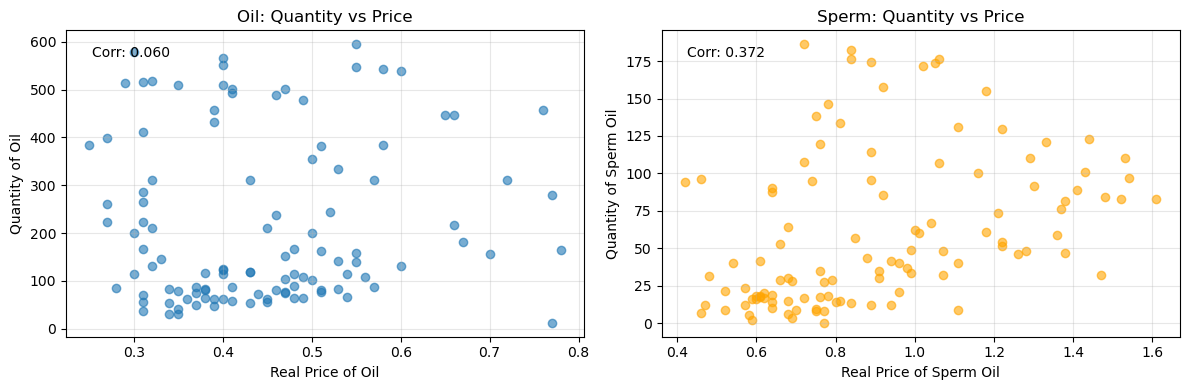

Oil correlation: 0.0602
Sperm correlation: 0.3716


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(df['price_oil_real'], df['oil'], alpha=0.6)
axes[0].set_xlabel('Real Price of Oil')
axes[0].set_ylabel('Quantity of Oil')
axes[0].set_title('Oil: Quantity vs Price')
axes[0].grid(True, alpha=0.3)
corr_oil = df[['price_oil_real', 'oil']].corr().iloc[0,1]
axes[0].text(0.05, 0.95, f'Corr: {corr_oil:.3f}', transform=axes[0].transAxes, va='top')

axes[1].scatter(df['price_sperm_real'], df['sperm'], alpha=0.6, color='orange')
axes[1].set_xlabel('Real Price of Sperm Oil')
axes[1].set_ylabel('Quantity of Sperm Oil')
axes[1].set_title('Sperm: Quantity vs Price')
axes[1].grid(True, alpha=0.3)
corr_sperm = df[['price_sperm_real', 'sperm']].corr().iloc[0,1]
axes[1].text(0.05, 0.95, f'Corr: {corr_sperm:.3f}', transform=axes[1].transAxes, va='top')

plt.tight_layout()
plt.show()

print(f"Oil correlation: {corr_oil:.4f}")
print(f"Sperm correlation: {corr_sperm:.4f}")

**Do you observe any correlations? Is this surprising or not?**

Oil Demand: Weak positive correlation (0.060) 

- SURPRISING (expect negative)

Sperm Demand: Moderate positive correlation (0.372)

- SURPRISING (expect negative)

Demand curves should show negative correlation (higher price would mean lower quantity). This results suggest that we're most likely observing supply shifts rather than demand shifts. Alternatively, there is some simultaneity bias by supply AND demand. Most likely they move together.

## Question 3: Price of Oil vs Price of Sperm

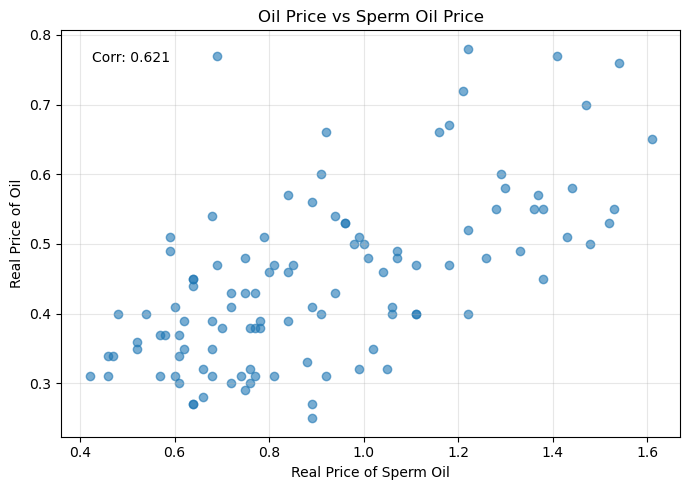

Price correlation: 0.6212


In [10]:
plt.figure(figsize=(7, 5))
plt.scatter(df['price_sperm_real'], df['price_oil_real'], alpha=0.6)
plt.xlabel('Real Price of Sperm Oil')
plt.ylabel('Real Price of Oil')
plt.title('Oil Price vs Sperm Oil Price')
plt.grid(True, alpha=0.3)
corr_prices = df[['price_sperm_real', 'price_oil_real']].corr().iloc[0,1]
plt.text(0.05, 0.95, f'Corr: {corr_prices:.3f}', transform=plt.gca().transAxes, va='top')
plt.tight_layout()
plt.show()

print(f"Price correlation: {corr_prices:.4f}")

**Do you observe any correlation? What might this suggest?**

Strong positive correlation (0.621)

**What this suggests:**

This results mean products are substitutes. e.g. when price of one increases, demand shifts to the other, raising its price. As a result, both prices respond to shared supply/demand shocks.

## Question 4: Demand Regressions

**What sign should we expect for β1 and β2?**

- Expected: β1 < 0 and β2 < 0 (negative coefficients)
- Why? Law of demand: as price increases, quantity demanded decreases. For demand equations Q = α + βP + ε, we expect β < 0 because price and quantity demanded are inversely related.

From Q2 we descriptively shown that this will not hold true. We want to estimate: Q = α + βP + ε, assuming that P is fixed. In reality, here, both Price (P) and Quantity (Q) are determined simultaneously by supply and demand. We will need to somehow isolate demand from the supply shift effect.

In [13]:

slope_oil, intercept_oil, r_oil, p_oil, se_oil = stats.linregress(df['price_oil_real'], df['oil'])
slope_sperm, intercept_sperm, r_sperm, p_sperm, se_sperm = stats.linregress(df['price_sperm_real'], df['sperm'])

results = pd.DataFrame({
    'Oil': [intercept_oil, slope_oil, se_oil, r_oil**2, p_oil],
    'Sperm': [intercept_sperm, slope_sperm, se_sperm, r_sperm**2, p_sperm]
}, index=['Intercept', 'Price Coef', 'Std Err', 'R²', 'p-value'])
print("Regression Results:")
print(results.round(4))

print(f"\nOil: Q = {intercept_oil:.2f} + {slope_oil:.2f} * P")
print(f"Sperm: Q = {intercept_sperm:.2f} + {slope_sperm:.2f} * P")

Regression Results:
                 Oil    Sperm
Intercept   181.2347   3.2559
Price Coef   84.5420  63.7079
Std Err     134.9313  15.3159
R²            0.0036   0.1381
p-value       0.5323   0.0001

Oil: Q = 181.23 + 84.54 * P
Sperm: Q = 3.26 + 63.71 * P


**Do the estimates make sense? Why or why not?**

- Oil (β1 = 84.54): Does NOT make sense for demand
- Sperm (β2 = 63.71): Does NOT make sense for demand

as was previously descriptevely shown in Q2.

We now statisticaly see, that a $1 price increase leads to ~84 more units sold for Oil ad ~64 more units sold for Sperm.

We expect negative coefficients (law of demand), but both are positive. Both price and quantity are endogenous (determined by supply AND demand).

## Question 5: Why Shipwrecks is Useful

Shipwrecks can serve as an instrumental variable since it affects supply (fewer ships means less oil produced), but does not directly affect demand!

Using shipwrecks as an instrument allows us to identify the demand curve by exploiting supply-side variation.